In [1]:
import gym
import time
from PIL import Image

In [13]:
print(list(gym.envs.registry.keys()))

['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4']


The observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
The action space: Discrete(3)


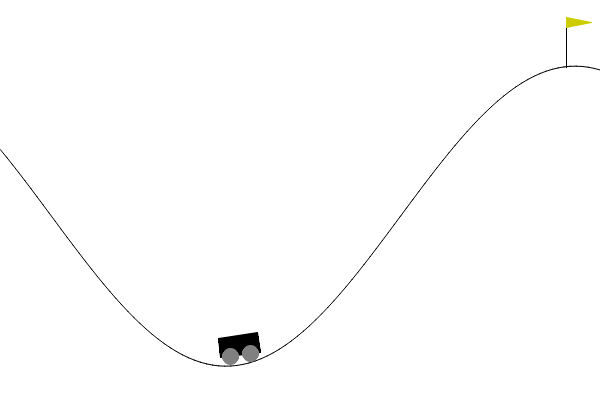

In [23]:
env = gym.make('MountainCar-v0', render_mode="rgb_array")

# Observation and action space 
print(f"The observation space: {env.observation_space}") 
print(f"The action space: {env.action_space}") 

# Display
obs = env.reset()
img = Image.fromarray(env.render())
img

In [15]:
# Reset environment to initial state
env = gym.make('MountainCar-v0', render_mode="human")
obs = env.reset()

for _ in range(1000):
    # Select a random action
    action = env.action_space.sample()

    # Apply the action to the environment (updated step return value)
    obs, reward, terminated, truncated, info = env.step(action)

    # break when terminated or truncated 
    if terminated or truncated:
        break

    # Render the environment
    env.render()
    
    # add delay
    time.sleep(0.05)

env.close()

# Training Agent

In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

In [2]:
# Define the deep Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQN agent class
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.99  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 64
        self.model = QNetwork(state_size, action_size)
        self.target_model = QNetwork(state_size, action_size)
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice(range(self.action_size))  # Explore
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.model(state)).item()  # Exploit

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.target_model(next_state)).item()

            target_f = self.model(state)
            target_f[0][action] = target

            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [13]:
import time

def train():
    env = gym.make('MountainCar-v0')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size)
    episodes = 500
    for e in range(episodes):
        state, info = env.reset()
        state = np.array(state)
        done = False
        total_reward = 0

        while not done:
            action = agent.act(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            next_state = np.array(next_state)
            done = terminated or truncated
            agent.remember(state, action, reward, next_state, done)
            agent.replay()
            state = next_state
            total_reward += reward

            # Render the environment (optional)
            # env.render()
            # time.sleep(0.05)

        agent.update_target_model()  # Update target model every episode
        print(f"Episode {e+1}/{episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

    env.close()

In [ ]:
train()

In [12]:
import pygame

# After the loop or training ends
pygame.quit()  # Explicitly quit pygame